# Homework #10
**Eric Nordstrom**  
  
Code not provided by me unless marked by the comment "### added by Eric ###"

In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd

In [10]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [12]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [14]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

* Calculate the date 1 year ago from the last data point in the database

* Perform a query to retrieve the data and precipitation scores

* Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

today: 2017-08-23
1 year ago: 2016-08-23


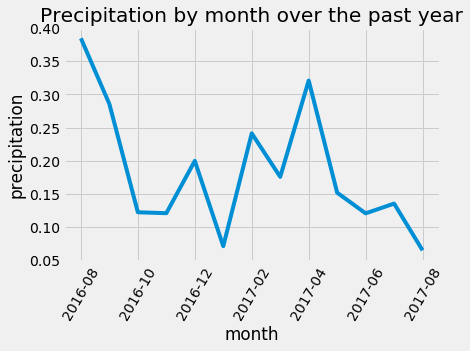

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [91]:
# Use Pandas to calcualte the summary statistics for the precipitation data

### added by Eric ###

today = session.query(func.max(Measurement.date)).first()[0]
print("today:", today)
one_year_ago = str(pd.to_datetime(today) - dt.timedelta(365)).split()[0]
print("1 year ago:", one_year_ago)

year_prcp= pd.read_sql(
    
    session.query(
        Measurement.date,
        Measurement.prcp,
    )
    .filter(Measurement.date > one_year_ago)
    .statement,
    
    con=engine

).set_index("date")\
.sort_index()

# daily data is too fine-grained to plot --> group by month
year_prcp.assign(month=[date[:7] for date in year_prcp.index])\
.groupby("month").mean().reset_index()\
.plot.line("month", "prcp")
plt.xticks(rotation=60)
plt.legend().remove()
plt.ylabel("precipitation")
plt.title("Precipitation by month over the past year")
plt.show()

year_prcp.describe()

In [93]:
# Design a query to show how many stations are available in this dataset?

### added by Eric ###

# stations from 'station' table
from_station = len(session.query(Station.id).all())
print("'station' table:", from_station)

# stations from 'measurement' table
from_meas = len(session.query(Measurement.station).distinct().all())
print("'measurement' table:", from_meas)

# compare
print("match:", from_station == from_meas)

'station' table: 9
'measurement' table: 9
match: True


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

### added by Eric ###

active_stations = pd.read_sql(
    
    session.query(
        func.min(Measurement.station).label("station"),
        func.count(Measurement.station).label("count")
    )
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .statement,
    
    con=engine

).set_index("station")

active_stations

,count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

### added by Eric ###

active = active_stations.index[0]
print("most active station:", active)

# find high/low temperatures from past year
low_temp = year_meas.tobs.min()
high_temp = year_meas.tobs.max()
mean_temp = year_meas.tobs.mean()
pd.DataFrame([[low_temp, mean_temp, high_temp]], columns=["low", "mean", "high"], index=[""])

most active station: USC00519281


,low,mean,high
,58.0,74.578947,87.0


no null temperature values:
[65. 63. 74. 76. 73. 70. 64. 68. 61. 66. 72. 69. 67. 71. 75. 77. 80. 78.
 79. 82. 87. 62. 58. 60. 85. 84. 83. 81. 59. 56. 57. 54. 86. 53. 55.]
most active stations over past year:
             count
station           
USC00519397    360
USC00519281    351
USC00516128    348
USC00513117    342
USC00519523    336
USC00514830    304
USC00517948    182

last 12 months of measurements for USC00519397:


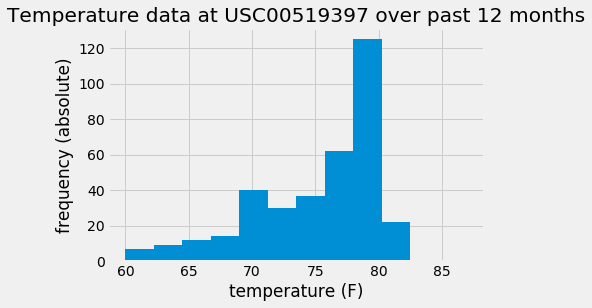

In [104]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

### added by Eric ###

# show that there are no null temperature values
print("no null temperature values:")
print(pd.read_sql(session.query(Measurement.tobs).statement, con=engine).tobs.unique())

# therefore, the station with the highest number of temperature observations is the most active station found before.
# this time, I'll find the most active station over the past year using a new query.

year_active = pd.read_sql(
    
    session.query(
        Measurement.station,
        func.count(Measurement.station).label("count"),
    )
    .filter(Measurement.date > one_year_ago)
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .statement,
    
    con=engine

).set_index("station")
print("\nmost active stations over past year:")
print(year_active)

active = year_active.index[0]
print(f"\nlast 12 months of measurements for {active}:")
year_active_temp = pd.read_sql(
    
    session.query(
        Measurement.date, 
        Measurement.station, 
        Measurement.tobs
    )
    .filter_by(station=active)
    .filter(Measurement.date > one_year_ago)
    .statement,
    
    con=engine

).set_index("date")
year_active_temp.hist(bins=12)
plt.title(f"Temperature data at {active} over past 12 months")
plt.xlabel("temperature (F)")
plt.ylabel("frequency (absolute)")
plt.show()

In [105]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

### added by Eric ###

def format_temps(temps):
    """formatting for calc_temps()"""
    
    return pd.DataFrame(temps, columns=["min", "avg", "max"], index=[""])

# formatted example of `calc_temps`
format_temps(calc_temps('2012-02-28', '2012-03-05'))

,min,avg,max
,62.0,69.571429,74.0


In [106]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

### added by Eric ###

# choose date range for trip
planned_start = '2018-05-16'
planned_end = '2018-05-25'

# these dates previous year
prev_start = str(int(planned_start[:4]) - 1) + planned_start[4:]
prev_end = str(int(planned_end[:4]) - 1) + planned_end[4:]

# get min, avg, max
prev_year_temps = calc_temps(prev_start, prev_end)
format_temps(prev_year_temps)

,min,avg,max
,68.0,74.631579,87.0


Text(0.5, 1.0, 'Trip Avg Temp')

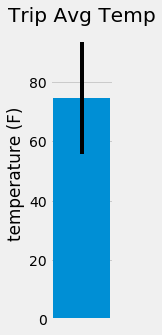

In [119]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

### added by Eric ###

min_temp, avg_temp, max_temp = prev_year_temps[0]
plt.figure(figsize=(1, 5))
plt.bar([0], [avg_temp], yerr=(max_temp - min_temp))
plt.xticks([])
plt.ylabel("temperature (F)")
plt.title("Trip Avg Temp")

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`